# Data Science for Cycling #3 - How To Calculate Elevation Difference and Distance From a GPX Route File
- Noteook 3/6
- Make sure to have the `haversine` package installed

        pip install haversine
        
- Let's import the libraries and tweak Matplotlib's default stylings:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haversine as hs

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

- Let's read in the dataset
- We've saved it to a CSV file in the first notebook:

In [2]:
route_df = pd.read_csv('../data/route_df.csv')
route_df.head()

,latitude,longitude,elevation
0,45.772480,15.958040,113.96
1,45.772770,15.959090,115.82
2,45.773270,15.958795,116.15
3,45.773770,15.958500,116.12
4,45.774235,15.959335,115.98


<br>

## Calculate elevation difference
- Put simply, you can use Python's `diff()` function to difference a column
- If you apply it to the Elevation column, you get the elevation difference between point T+1 and T
- The first differenced value will be Null, as there's no data point before it:

In [3]:
route_df['elevation_diff'] = route_df['elevation'].diff()

route_df.head()

,latitude,longitude,elevation,elevation_diff
0,45.772480,15.958040,113.96,NaN
1,45.772770,15.959090,115.82,1.86
2,45.773270,15.958795,116.15,0.33
3,45.773770,15.958500,116.12,-0.03
4,45.774235,15.959335,115.98,-0.14


<br>

## Calculate distance between geolocations
- Calculating distance is tricky in this case
- It's best to use Google's API
    - But it's not free
    - And applies to road, which is limiting for let's say mountain bike trails
- The best free option is to use **haversine distance**
    - It calculates a great circle distance between two points on a sphere given their latitudes and longitudes
    - Learn more: https://en.wikipedia.org/wiki/Haversine_formula
- The GPX route measures 36,4 kilometers and has 835 data points
    - Which means there's on average 43,6 meters between two points
    - Haversine distance will be off, but hopefully not much
- Let's first define a function to calculate haversine distance:

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2) -> float:
    distance = hs.haversine(
        point1=(lat1, lon1),
        point2=(lat2, lon2),
        unit=hs.Unit.METERS
    )
    return np.round(distance, 2)

- Let's test it
- The example below measures the distance between the first and the second point:

In [5]:
haversine_distance(
    lat1=route_df.iloc[0]['latitude'],
    lon1=route_df.iloc[0]['longitude'],
    lat2=route_df.iloc[1]['latitude'],
    lon2=route_df.iloc[1]['longitude']
)

87.59

- It's 87,59 meters, but we can't verify it through Strava
- Let's calculate the distances between all data points
    - We have to skip the first row as there's no data point before it:

In [6]:
distances = [np.nan]

for i in range(len(route_df)):
    if i == 0:
        continue
    else:
        distances.append(haversine_distance(
            lat1=route_df.iloc[i - 1]['latitude'],
            lon1=route_df.iloc[i - 1]['longitude'],
            lat2=route_df.iloc[i]['latitude'],
            lon2=route_df.iloc[i]['longitude']
        ))
        
route_df['distance'] = distances
route_df.head()

,latitude,longitude,elevation,elevation_diff,distance
0,45.772480,15.958040,113.96,NaN,NaN
1,45.772770,15.959090,115.82,1.86,87.59
2,45.773270,15.958795,116.15,0.33,60.12
3,45.773770,15.958500,116.12,-0.03,60.12
4,45.774235,15.959335,115.98,-0.14,82.87


### Total Uphill
- How to calculate it?
- Simple - subset the column so only the rows with positive `elevation_diff` are kept, and then calculate the sum of the elevation difference:

In [7]:
route_df[route_df['elevation_diff'] >= 0]['elevation_diff'].sum()

311.97999999999996

- The official Strava route states there's 288 meters of elevation, so we're a bit off

### Total Distance
- To calculate the total distance, simply sum the `distance` column:

In [8]:
route_df['distance'].sum()

36449.990000000005

- The official Strava route states 36,4 km - we're dead on even with the simple haversine distance calculation!

<br>

## Visualize the Elevation profile
- Let's see if our calculations make sense by visualizing the elevation profile
    - Shows meters of climbing at different distances
- To make things simpler, we'll calculate a cumulative sum for elevation and distance

In [9]:
route_df['cum_elevation'] = route_df['elevation_diff'].cumsum()
route_df['cum_distance'] = route_df['distance'].cumsum()

route_df.head()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance
0,45.772480,15.958040,113.96,NaN,NaN,NaN,NaN
1,45.772770,15.959090,115.82,1.86,87.59,1.86,87.59
2,45.773270,15.958795,116.15,0.33,60.12,2.19,147.71
3,45.773770,15.958500,116.12,-0.03,60.12,2.16,207.83
4,45.774235,15.959335,115.98,-0.14,82.87,2.02,290.70


- Let's get rid of the NaNs
- We'll fill the NaNs with zeros, as that makes more sense for this dataset:

In [10]:
route_df = route_df.fillna(0)

route_df.head()

,latitude,longitude,elevation,elevation_diff,distance,cum_elevation,cum_distance
0,45.772480,15.958040,113.96,0.00,0.00,0.00,0.00
1,45.772770,15.959090,115.82,1.86,87.59,1.86,87.59
2,45.773270,15.958795,116.15,0.33,60.12,2.19,147.71
3,45.773770,15.958500,116.12,-0.03,60.12,2.16,207.83
4,45.774235,15.959335,115.98,-0.14,82.87,2.02,290.70


- We'll save this dataset for the upcoming notebooks:

In [11]:
route_df.to_csv('../data/route_df_elevation_distance.csv', index=False)

- Finally, let's use Matplotlib to plot the elevation profile:

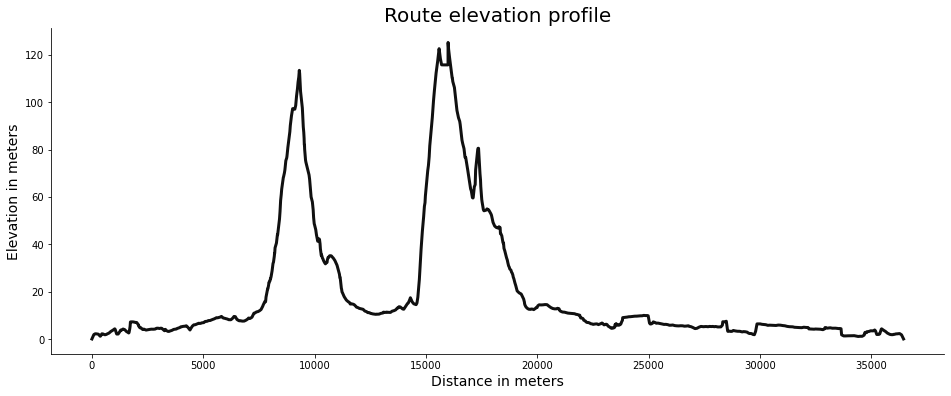

In [14]:
plt.plot(route_df['cum_distance'], route_df['cum_elevation'], color='#101010', lw=3)
plt.title('Route elevation profile', size=20)
plt.xlabel('Distance in meters', size=14)
plt.ylabel('Elevation in meters', size=14);
plt.savefig('fig.jpg', dpi=300, bbox_inches='tight')

- It's difficult to say if it looks exactly like the one on Strava, but it looks almost identical!
- In the next notebook, you'll learn how to calculate gradients based on the elevation difference and distance between the data points.